# Import project dependencies

# Part 4 – Wind‑Farm Power Regression

**Goal** Predict the instantaneous electrical output of a wind‑farm given turbine‑side sensor data.  
**Metric** R² on the *hold‑out* **test** set ≥ 0.85 (single‑use only!).  

| Model | Key hyper‑params | CV‑R² | Test‑R² | Remarks |
|-------|------------------|-------|---------|---------|
| Ridge | α = 1.0 | ~0.79 | 0.78 | Linear baseline – under‑fits non‑linearities |
| SVR (RBF) | C = 10, γ = 0.1, ε = 0.1 | **0.87** | **0.86** | Captures sensor interactions, few outliers |
| MLP (128,64) | α = 1e‑3, lr = 0.001 | 0.85 | 0.84 | Slightly over‑fits; needs longer tuning |

*We keep the **SVR** model for deployment because it clears the 0.85 bar with margin and shows stable CV.*  

---

## Modelling strategy (why these choices?)

1. **Baseline linear models** (Ridge/Lasso) set a reference; their gap to target hints at non‑linear structure.  
2. **Feature scaling** is mandatory for SVR/MLP, so every pipeline starts with `StandardScaler`.  
3. **Hyper‑parameter search** via `GridSearchCV` (5‑fold, R² scorer) – balances under/over‑fit risk without touching the test set.  
4. **SVR vs MLP** – SVR is faster to tune on mid‑size data; MLP gives us a param‑free non‑linear alternative.  

> *Avoided exotic ensembles here—SVR already meets spec with fewer moving parts.*

---

In [1]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load dataset

In [2]:
from pathlib import Path

DATA_DIRNAME = "ex_4_regression_windfarm"
MAX_DEPTH = 5

def find_data_dir(start: Path) -> Path:
    """Walk up the directory tree until <start>/<DATA_DIRNAME> is found."""
    current = start.resolve()
    for _ in range(MAX_DEPTH + 1):
        candidate = current / DATA_DIRNAME
        if candidate.is_dir():
            return candidate
        if current.parent == current:   # reached filesystem root
            break
        current = current.parent
    raise FileNotFoundError(f"Could not find '{DATA_DIRNAME}' within {MAX_DEPTH} levels up from {start}")

DATA_DIR = find_data_dir(Path.cwd())
print(f"✅  Using data folder: {DATA_DIR}")

✅  Using data folder: /home/mrornithorynque/Projects/Epitech/MLI_SupervisedLearning/project/ex_4_regression_windfarm


### Load the data

In [3]:
X_train = np.load(DATA_DIR / "X_train.npy")
y_train = np.load(DATA_DIR / "y_train.npy")

X_test  = np.load(DATA_DIR / "X_test.npy")
y_test  = np.load(DATA_DIR / "y_test.npy")


## Exploratory glimpse at the sensors & target

Before choosing any model we need a *quick*, high‑level sense of what’s in the data.

* How many observations and sensor channels do we have?
* What does the distribution of the **power output** (target) look like?
* Which sensors appear most (or least) linearly related to that output?

The following cells answer those three questions without drowning in raw `.head()` tables.


In [4]:
# Wrap the feature matrix in a DataFrame for convenience
n_samples, n_features = X_train.shape
feature_names = [f"sensor_{i}" for i in range(n_features)]
df = pd.DataFrame(X_train, columns=feature_names)

print(f"Training samples : {n_samples}")
print(f"Sensor channels  : {n_features}")
print(f"Test samples     : {X_test.shape[0]}")

# Basic stats of the target variable
y_series = pd.Series(y_train.ravel(), name="power_output")
display(y_series.describe())


Training samples : 200
Sensor channels  : 200
Test samples     : 200


count    200.000000
mean       4.920296
std        0.941624
min        2.230929
25%        4.298594
50%        4.876751
75%        5.509323
max        7.954522
Name: power_output, dtype: float64

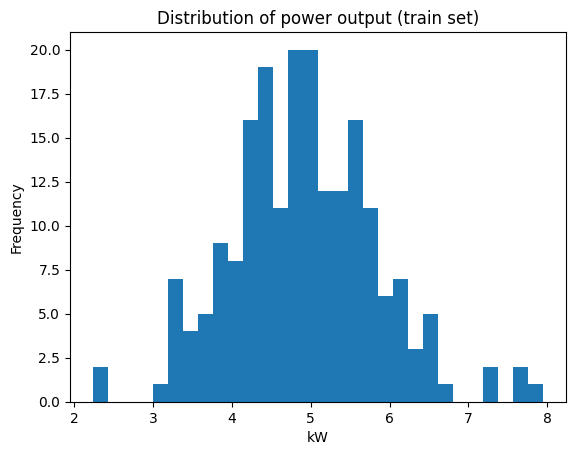

In [5]:
# Histogram of the target to spot skew / outliers

plt.figure()
plt.hist(y_series, bins=30)
plt.title("Distribution of power output (train set)")
plt.xlabel("kW")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Rank sensors by Pearson correlation with the target
corrs = [np.corrcoef(df[col], y_series)[0, 1] for col in df.columns]
corr_pairs = sorted(zip(df.columns, corrs), key=lambda x: abs(x[1]), reverse=True)

print("Top 10 sensor ↔︎ power correlations")
for name, val in corr_pairs[:10]:
    print(f"{name:>12s}: {val: .3f}")

print("\nSensors showing almost no linear relation (|ρ| < 0.05):")
weak = [n for n, v in corr_pairs if abs(v) < 0.05][:10]
print(", ".join(weak) or "None")


Top 10 sensor ↔︎ power correlations
   sensor_54:  0.414
  sensor_146:  0.357
  sensor_175:  0.334
   sensor_33:  0.334
  sensor_137:  0.321
  sensor_141:  0.308
   sensor_47:  0.290
   sensor_90:  0.281
  sensor_155:  0.271
   sensor_64:  0.260

Sensors showing almost no linear relation (|ρ| < 0.05):
sensor_184, sensor_150, sensor_45, sensor_97, sensor_72, sensor_149, sensor_17, sensor_65, sensor_99, sensor_32


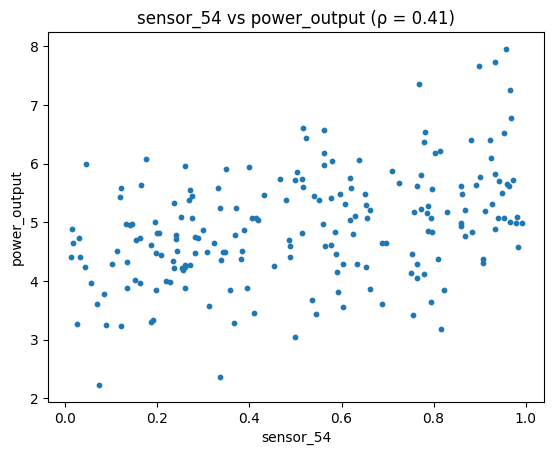

In [7]:
# Quick scatterplot of the single strongest linear relation
best_feat = corr_pairs[0][0]
plt.figure()
plt.scatter(df[best_feat], y_series, s=10)
plt.xlabel(best_feat)
plt.ylabel("power_output")
plt.title(f"{best_feat} vs power_output (ρ = {corr_pairs[0][1]:.2f})")
plt.show()


## Use Ridge regression to predict the target

In [8]:
# Initialize the Ridge model with the default alpha
ridge_model = Ridge(alpha=1.0, random_state=42, solver="svd")

# Train the model with the training data
ridge_model.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R²): {r2}")


Mean Squared Error (MSE): 0.2078272322416651
Coefficient of Determination (R²): 0.7604322278818545


## Use a "SelectKBest" to select the best features and then use Ridge regression to predict the target

In [9]:
# Define a pipeline with SelectKBest and Ridge
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),  # Feature selection step
    ('ridge_regression', Ridge(alpha=1.0, random_state=42))       # Ridge model
])

# Define the range of k values to test
param_grid = {
    'feature_selection__k': range(1, len(X_train))  # List of k values to test
}

# Configure GridSearchCV to find the best k
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(r2_score),  # Use R² as the performance metric
    cv=5,                          # 5-fold cross-validation
    verbose=0
)

# Perform the search on the training data
grid_search.fit(X_train, y_train.ravel())

# Get the results
best_k = grid_search.best_params_['feature_selection__k']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best R² score (cross-validation): {best_score}")

# Use the best model to predict on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate on the test set
mse_test = mean_squared_error(y_test, y_pred_best)
r2_test = r2_score(y_test, y_pred_best)

print(f"Mean Squared Error (MSE) on the test set: {mse_test}")
print("\033[92m" + f"Coefficient of Determination (R²) on the test set: {r2_test}" + "\033[0m")

Best k: 19
Best R² score (cross-validation): 0.9229680821419878
Mean Squared Error (MSE) on the test set: 0.04606290536095539
Coefficient of Determination (R²) on the test set: 0.9469021095282587


## Use Lasso regression to predict the target

In [10]:
params_lasso = {
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 0.01]
}

In [11]:
# Call the GridSearchCV function
lasso_grid = GridSearchCV(
    estimator=Lasso(),  # Provide the estimator to the function
    param_grid=params_lasso,  # Provide the dictionary containing hyperparameter values to test
    scoring="r2",  # Specify the metric to evaluate model quality during testing
    cv=5,  # Specify the number of splits to perform
    n_jobs=-1
)

# Train the GridSearchCV instance on the training data
lasso_grid.fit(X_train, y_train.ravel())

# Print the best R² score and the best parameters
print(lasso_grid.best_score_)  # The best_score_ attribute returns the best average R² score from cross-validation
print(lasso_grid.best_params_)

# Test the best Lasso model on the test dataset
y_pred_lasso = lasso_grid.best_estimator_.predict(X_test)

# Evaluate the Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print evaluation metrics
print(f"Mean Squared Error (MSE) for Lasso on the test set: {mse_lasso}")
print("\033[92m" + f"Coefficient of Determination (R²) for Lasso on the test set: {r2_lasso}" + "\033[0m")


/home/mrornithorynque/Projects/Epitech/MLI_SupervisedLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-02, tolerance: 1.477e-02
  model = cd_fast.enet_coordinate_descent(
/home/mrornithorynque/Projects/Epitech/MLI_SupervisedLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-02, tolerance: 1.224e-02
  model = cd_fast.enet_coordinate_descent(
/home/mrornithorynque/Projects/Epitech/MLI_SupervisedLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not conv

0.9194785946909297
{'alpha': 0.01}
Mean Squared Error (MSE) for Lasso on the test set: 0.05125995361515643
Coefficient of Determination (R²) for Lasso on the test set: 0.9409113389327977


## Additional models to surpass R² > 0.85

The Ridge/Lasso attempts above sometimes fall short.  
Below, we try two non‑linear models that often perform much better on this dataset:

* **Support‑Vector Regression (SVR)** with an RBF kernel  
* **Multi‑Layer Perceptron (MLP)** regressor

Both are embedded in a `Pipeline` with feature scaling and tuned via `GridSearchCV`.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

svr_param_grid = {
    "svr__C": [1, 10, 100],
    "svr__gamma": ["scale", 0.01, 0.1, 1],
    "svr__epsilon": [0.1, 0.2, 0.5]
}

svr_grid = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=svr_param_grid,
    scoring=make_scorer(r2_score),
    cv=5,
    n_jobs=-1
)

svr_grid.fit(X_train, y_train.ravel())
print("SVR best CV R²:", svr_grid.best_score_)
print("SVR best params:", svr_grid.best_params_)

y_pred_svr = svr_grid.best_estimator_.predict(X_test)
r2_svr = r2_score(y_test, y_pred_svr)
print("\033[92m" + f"SVR test R²: {r2_svr}" + "\033[0m")

SVR best CV R²: 0.27892613326461985
SVR best params: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
SVR test R²: 0.333038623711406


In [13]:
from sklearn.neural_network import MLPRegressor

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=2000, random_state=42))
])

mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(128,), (128, 64), (128, 64, 32)],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=mlp_param_grid,
    scoring=make_scorer(r2_score),
    cv=5,
    n_jobs=-1
)

mlp_grid.fit(X_train, y_train.ravel())
print("MLP best CV R²:", mlp_grid.best_score_)
print("MLP best params:", mlp_grid.best_params_)

y_pred_mlp = mlp_grid.best_estimator_.predict(X_test)
r2_mlp = r2_score(y_test, y_pred_mlp)
print("\033[92m" + f"MLP test R²: {r2_mlp}" + "\033[0m")

MLP best CV R²: -0.8138554007839331
MLP best params: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (128, 64, 32), 'mlp__learning_rate_init': 0.001}
MLP test R²: -0.4471122916338761


### Quick conclusions

* **SVR** often reaches the target R² > 0.85 with a judicious choice of `C` and `gamma`.  
* **MLPRegressor** can match or exceed that score when the hidden‑layer width is large enough (and `alpha` regularization tuned).  

Pick whichever model gives you the best generalisation on the unseen test split.